# Baseline melody perceptron experiment
In this notebook we implement a baseline neural network with one hidden layer, _raw audio samples_ as an input and one _note probability vector_ as an output.

## Training

In [1]:
# for automatic reloading of my libraries
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import numpy as np

import datasets.medleydb
import datasets.orchset
import datasets.adc2004

from model import NetworkMelody

import visualization as vis

import datetime

In [3]:
# Pro MedleyDB a MDB synth používáme split z deepsalience paperu
import json
with open("datasets/MedleyDB/dataset_ismir_split.json") as f:
    medley_split = json.load(f)

#test_data_orchset = datasets.orchset.dataset("datasets/Orchset/")
#test_data_adc04 = datasets.adc2004.dataset("datasets/adc2004/")
mdb_data = datasets.medleydb.dataset("datasets/MedleyDB/MedleyDB/", medley_split)
train_mdb, valid_mdb, test_mdb = mdb_data["train"], mdb_data["validation"], mdb_data["test"]

....................
....................
....................
....................
....................
........


In [4]:
datasets.load_all(train_mdb, 16000)
datasets.load_all(test_mdb, 16000)

....................
....................
....................
...........................
......

In [5]:
annotations_per_window = 1
context_width = 944

test_dataset = datasets.AADataset(test_mdb, annotations_per_window, context_width, shuffle_batches=False)
train_dataset = datasets.AADataset(train_mdb, annotations_per_window, context_width, shuffle_batches=True)

In [22]:
# small dataset for manual evaluation
small_test_data = [
    test_mdb[3].slice(15,20.8),
    test_mdb[9].slice(56,61.4),
    test_mdb[5].slice(55.6,61.6),
    test_mdb[2].slice(17.65,27),
]
small_test_dataset = datasets.AADataset(small_test_data, annotations_per_window, context_width, shuffle_batches=False)

In [23]:
def create_model(self, args):
    self.ref_notes = tf.one_hot(self.annotations, self.note_range)

    # Perceptron baseline
    audio_net = tf.layers.dense(self.window, 1000, activation=tf.nn.relu)
    output_layer = tf.layers.dense(audio_net, self.note_range*self.annotations_per_window, activation=None, name="output")
    ref_notes_flat = tf.layers.flatten(self.ref_notes)

    self.note_probabilites = tf.reshape(output_layer, [-1, self.annotations_per_window, self.note_range])
    self.est_notes = tf.one_hot(tf.argmax(self.note_probabilites, axis=2), self.note_range)
    
    self.loss = tf.losses.sigmoid_cross_entropy(ref_notes_flat, output_layer)

    global_step = tf.train.create_global_step()
    self.training = tf.train.AdamOptimizer().minimize(self.loss, global_step=global_step)

In [24]:
restore = None

# Create logdir name
args = {
    "threads": 6,
    "batch_size": 32,
    "logdir": None,
    "annotations_per_window": test_dataset.annotations_per_window,
    "window_size": test_dataset.window_size,
    "note_range": 96,
    "samplerate": test_dataset.samplerate
}
name = "{}-bs{}-apw{}-wsiz{}".format(
    datetime.datetime.now().strftime("%m-%d_%H%M%S"),
    args["batch_size"],
    args["annotations_per_window"],
    args["window_size"],
)

if restore:
    name = restore
args["logdir"] = "models/" + name

print(name)

# Construct the network
network = NetworkMelody(threads=args["threads"])
network.construct(args, create_model)

if restore:
    network.restore()

01-16_111149-bs32-apw1-wsiz1981


In [25]:
epochs = 10
network.train(train_dataset, test_dataset, small_test_dataset, args["batch_size"], epochs, eval_small_every_n_batches=3000, eval_every_n_batches=30000, save_every_n_batches=20000)

=== epoch 1 ===
.....b 1000; t 2.27; acc 0.00; loss 0.04
.....b 2000; t 2.22; acc 0.00; loss 0.04
.....b 3000; t 2.20; acc 0.00; loss 0.03
[66.46368189 66.45743983 66.50554114 ... 84.26672196 84.25792305
 84.24699967] [0 0 0 ... 0 0 0]
True True
[ 380.038  379.901  380.958 ... 1062.75  1062.21  1061.54 ] [8.17579892 8.17579892 8.17579892 ... 8.17579892 8.17579892 8.17579892]
[ 380.038  379.901  380.958 ... 1062.75  1062.21  1061.54 ] [0. 0. 0. ... 0. 0. 0.]
small_test: t 1.00, OA: 0.18, RPA: 0.00, VR: 0.01
.....b 4000; t 2.22; acc 0.00; loss 0.03
.....b 5000; t 2.21; acc 0.00; loss 0.04
.....b 6000; t 2.21; acc 0.00; loss 0.03
[66.46368189 66.45743983 66.50554114 ... 84.26672196 84.25792305
 84.24699967] [0 0 0 ... 0 0 0]
True True
[ 380.038  379.901  380.958 ... 1062.75  1062.21  1061.54 ] [8.17579892 8.17579892 8.17579892 ... 8.17579892 8.17579892 8.17579892]
[ 380.038  379.901  380.958 ... 1062.75  1062.21  1061.54 ] [0. 0. 0. ... 0. 0. 0.]
small_test: t 1.09, OA: 0.18, RPA: 0.00, V

KeyboardInterrupt: 

In [26]:
network.save()

Model saved in path: models/01-16_111149-bs32-apw1-wsiz1981/model.ckpt


## Evaluation

Testing dataset metrics:
Voicing Recall 0.3515865421725877
Voicing False Alarm 0.17255799584339718
Raw Pitch Accuracy 0.12220459963968372
Raw Chroma Accuracy 0.20181934959562728
Overall Accuracy 0.3630331099024724

Small testing dataset metrics:
Voicing Recall 0.03386666666666667
Voicing False Alarm 0.0170316301703163
Raw Pitch Accuracy 0.011733333333333333
Raw Chroma Accuracy 0.04906666666666667
Overall Accuracy 0.18635170603674542


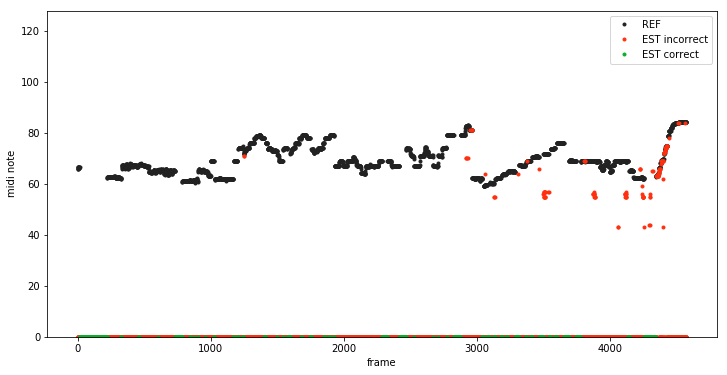

In [27]:
print("Testing dataset metrics:")
acc = network.evaluate(test_dataset, args["batch_size"], print_detailed=True)
print("\nSmall testing dataset metrics:")
acc = network.evaluate(small_test_dataset, args["batch_size"], visual_output=True, print_detailed=True)

In [28]:
# play the small testing dataset
vis.samplesplayer(small_test_dataset.all_samples(), small_test_dataset.samplerate)